## **Conclusion**

1. Tree-base model is better than logistic regression model but it is no good enough for business decisions. In order to improve model, it would be helpful to have more data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Also it could be helpful to know the monthly count of unique starting and ending locations each driver inputs.

2. There are some comprison points with tree-base model and logistic regression model: 

- Tree-based model ensembles are often better than logistic regression model. They also require less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables.

- Logistic regression model are easier to interpret because they assign coefficients to predictor variables that directly present the weight of variables. In other word, it tell that each feature is positively or negatively correlated with the target in the model's final prediction.

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option("display.max_columns", None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [3]:
# Copy the df0 dataframe
df = df0.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


### 1. **Create new feature**

#### **`km_per_driving_day`**




In [5]:
# 1. Create `km_per_driving_day` feature
df["km_per_driving_day"] = df["driven_km_drives"] / df["driving_days"]

# 2. Get descriptive stats
df["km_per_driving_day"].describe()

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [6]:
# 1. Convert infinite values to zero
df.loc[df["km_per_driving_day"] == np.inf, "km_per_driving_day"] =0

# 2. Confirm that it worked
df["km_per_driving_day"].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

In [7]:
# 1. Create `percent_sessions_in_last_month` feature
df["percent_sessions_in_last_month"] = df["sessions"] / df["total_sessions"]

# 1. Get descriptive stats
df["percent_sessions_in_last_month"].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [8]:
# Create `professional_driver` feature
df["proffessional_driver"] = np.where((df["drives"] >= 60) & (df["driving_days"] >= 15), 1, 0)

#### **`total_sessions_per_day`**

In [9]:
# Create `total_sessions_per_day` feature
df["total_sessions_per_day"] = df["total_sessions"] / df["n_days_after_onboarding"]
df["total_sessions_per_day"].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

In [10]:
# Create `km_per_hour` feature
df["km_per_hour"] = df["driven_km_drives"] / (df["duration_minutes_drives"] / 60)
df["km_per_hour"].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

#### **`km_per_drive`**


In [11]:
# Create `km_per_drive` feature
df["km_per_drive"] = df["driven_km_drives"] / df["drives"]
df["km_per_drive"].describe()

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [12]:
# 1. Convert infinite values to zero
df.loc[df["km_per_drive"] == np.inf, "km_per_drive"] = 0

# 2. Confirm that it worked
df["km_per_drive"].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**


In [13]:
# Create `percent_of_sessions_to_favorite` feature
df["percent_of_drives_to_favorite"] = (
    df["total_navigations_fav1"] + df["total_navigations_fav2"]) / df["total_sessions"]

# Get descriptive stats
df["percent_of_drives_to_favorite"].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

### **2. Clean and balance class**

In [14]:
# Drop rows with missing values
df = df.dropna(subset = ["label"])

In [15]:
# Examine the calss balance
df["label"].value_counts()

label
retained    11763
churned      2536
Name: count, dtype: int64

In [16]:
# Use resampling to create class balance in the outcome variable

data_minority = df[df["label"] == "churned"]
data_majority = df[df["label"] == "retained"]
data_minority_upsampled = resample(data_minority,
                                   replace=True,                 # to sample with replacement
                                   n_samples=len(data_majority), # to match majority class
                                   random_state=0)


df = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)
df["label"].value_counts()

label
retained    11763
churned     11763
Name: count, dtype: int64

In [17]:
# Create new `device2` variable
df["device2"] = np.where(df["device"] == "Android", 0, 1)
df[["device", "device2"]].tail()

,device,device2
23521,iPhone,1
23522,Android,0
23523,iPhone,1
23524,iPhone,1
23525,iPhone,1


In [18]:
# Create binary `label2` column
df["label2"] = np.where(df["label"] == "churned", 1, 0)
df[["label", "label2"]].tail()

,label,label2
23521,churned,1
23522,churned,1
23523,churned,1
23524,churned,1
23525,churned,1


### **3. Split data and train model**

In [19]:
x = df.drop(columns=["ID", "label", "label2", "device"])
y = df["label2"]

x_tr, x_test, y_tr, y_test = train_test_split(x, y, stratify=y,
                                              test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

### Random Forest 

In [20]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state = 42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {"max_depth" : [None],
             "max_features" : [1.0, 0.5],
             "max_samples" : [1.0, 0.5],
             "min_samples_leaf" : [2, 4],
             "min_samples_split" : [2, 4],
             "n_estimators" : [300]}

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# 3. Define a set of scoring metrics to capture
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)}


# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = "recall")

In [21]:
%%time
rf_cv.fit(x_train, y_train)

CPU times: total: 30min 24s
Wall time: 33min 41s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0, 0.5],
                         'max_samples': [1.0, 0.5], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4], 'n_estimators': [300]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

In [22]:
# Examine best score
rf_cv.best_score_

0.9311401142137686

In [23]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.5,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [24]:
def make_results(model_name:str, model_object, metric:str):

  # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {"precision" : "mean_test_precision",
                   "recall" : "mean_test_recall",
                   "f1" : "mean_test_f1",
                   "accuracy" :"mean_test_accuracy" }

  # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  # Create table of results
    table = pd.DataFrame({"model" : [model_name],
                        "precision" : [precision], 
                        "recall" : [recall],
                        "F1" : [f1],
                        "accuracy" : [accuracy]})
    
    return table

In [25]:
results = make_results("RF CV", rf_cv, "recall")
results

,model,precision,recall,F1,accuracy
0,RF CV,0.837253,0.93114,0.881689,0.875026


### XGBoost 

In [26]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective = "binary:logistic", random_state = 42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {"max_depth" : [6, 12], 
            "min_child_weight" : [3, 5],
            "learning_rate" : [0.01, 0.1],
            "n_estimators" : [300]}

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# 3. Define a set of scoring metrics to capture
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)}


# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring, cv = 4, refit = "recall")

In [27]:
%%time
xgb_cv.fit(x_train, y_train)

CPU times: total: 2min 41s
Wall time: 51.5 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

In [28]:
# Examine best score
xgb_cv.best_score_

0.9307155865178933

In [29]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [30]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results("XGB CV", xgb_cv, "recall" )
results = pd.concat([results, xgb_cv_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.837253,0.931140,0.881689,0.875026
0,XGB CV,0.838234,0.930716,0.882050,0.875522


### **4. Validate model**

### Random forest

In [31]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(x_val)

In [32]:
def get_test_scores(model_name:str, preds, y_test_data):

    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [33]:
# Get validation scores for RF model
rf_val_scores = get_test_scores("RF VAL", rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.837253,0.931140,0.881689,0.875026
0,XGB CV,0.838234,0.930716,0.882050,0.875522
0,RF VAL,0.869144,0.954507,0.909828,0.905420


### XGBoost

In [34]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(x_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores("XGB VAL", xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.837253,0.931140,0.881689,0.875026
0,XGB CV,0.838234,0.930716,0.882050,0.875522
0,RF VAL,0.869144,0.954507,0.909828,0.905420
0,XGB VAL,0.856224,0.962160,0.906106,0.900319


### **5. Choose the champion model**

In [35]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(x_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores("XGB TEST", xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.837253,0.931140,0.881689,0.875026
0,XGB CV,0.838234,0.930716,0.882050,0.875522
0,RF VAL,0.869144,0.954507,0.909828,0.905420
0,XGB VAL,0.856224,0.962160,0.906106,0.900319
0,XGB TEST,0.862476,0.962176,0.909602,0.904377


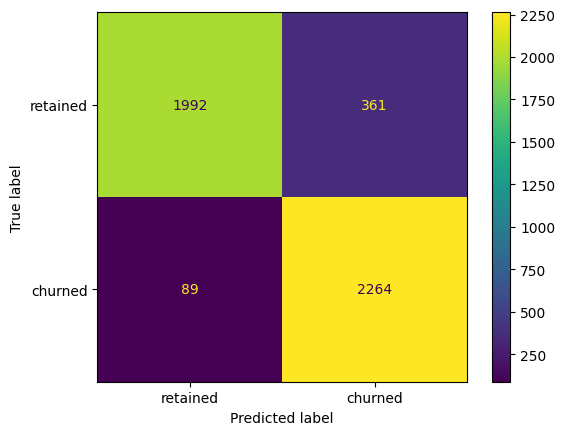

In [39]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels = xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ["retained", "churned"])
disp.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

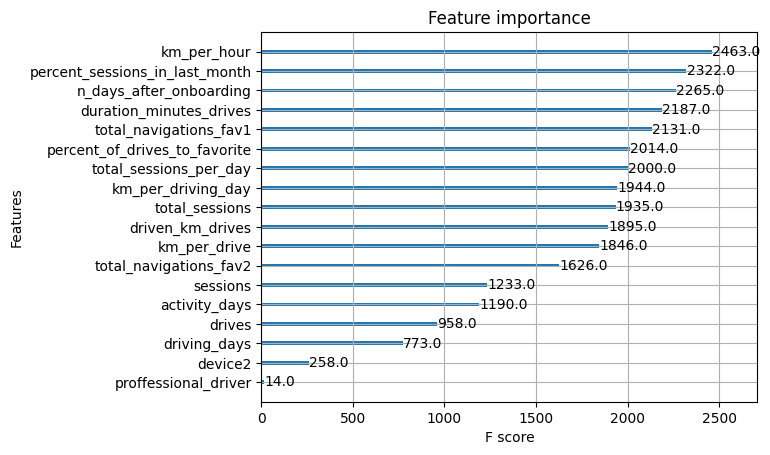

In [37]:
plot_importance(xgb_cv.best_estimator_)